In [1]:
# !apt-get install openjdk-17-jre-headless -qq > /dev/null
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
# !update-alternatives --set java /usr/lib/jvm/java-17-openjdk-amd64/bin/java
# !java -version
# !pip install torch torchvision torchaudio
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install capymoa

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 15.2 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=0f7a959db4824a07cba47822e09a6646d88dba11149dbda66164918d7e1704f1
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


The following is a json which is used to put different models and configurations for automl modules. We save it so the methods can read the file directly.

In [2]:
import json
conf = {

  # "windowSize" :  1000,
  "ensembleSize" : 10,
  "newConfigurations" : 10,
  "keepCurrentModel" : True,
  "lambda" : 0.05,
  "preventAlgorithmDeath" : True,
  "keepGlobalIncumbent" : True,
  "keepAlgorithmIncumbents" : True,
  "keepInitialConfigurations" : True,
  "useTestEnsemble" : True,
  "resetProbability" : 0.01,
  "numberOfCores" : 1,
  "performanceMeasureMaximisation": True,

  "algorithms": [
    {
      "algorithm": "moa.classifiers.lazy.kNN",
      "parameters": [
        {"parameter": "k", "type":"integer", "value":10, "range":[2,30]}
      ]
    }
  ,
    {
      "algorithm": "moa.classifiers.trees.HoeffdingTree",
      "parameters": [
        {"parameter": "g", "type":"integer", "value":200, "range":[10, 200]},
       {"parameter": "c", "type":"float", "value":0.01, "range":[0, 1]}
      ]
    }
  ,
    # {
    #   "algorithm": "moa.classifiers.lazy.kNNwithPAWandADWIN",
    #   "parameters": [
    #     {"parameter": "k", "type":"integer", "value":10, "range":[2,30]}
    #   ]
    # }
    # ,
    {
      "algorithm": "moa.classifiers.trees.HoeffdingAdaptiveTree",
      "parameters": [
        {"parameter": "g", "type":"integer", "value":200, "range":[10, 200]},
        {"parameter": "c", "type":"float", "value":0.01, "range":[0, 1]}
      ]
    }

  ]
}

with open('settings_autoclass.json', 'w') as fp:
    json.dump(conf, fp)

## AutoML in CapyMOA

In [3]:
import os
import math
import time
import json
import itertools
import importlib
import numpy as np
from capymoa.base import Classifier
from capymoa.automl import AutoClass
from typing import List, Dict, Any, Optional, Union
from capymoa.evaluation import ClassificationEvaluator
from capymoa.datasets import Electricity, RBFm_100k
from capymoa.evaluation import prequential_evaluation
from capymoa.stream.generator import RandomTreeGenerator, SEA
from capymoa.stream.drift import DriftStream, AbruptDrift, GradualDrift
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import *

In [4]:
def print_summary(label: str, results):
    print(
        f"{label.ljust(10)} Cumulative accuracy = {results.accuracy():.2f}, "
        f"wall-clock time: {results.wallclock():.3f}"
)

In [5]:
# Define a generic adaptive learning function
def stream_learning_model_selection(model_list, window_size, max_instances):
    best_accuracy = 0  # The best accuracy score
    all_results = {}
    for model in model_list:
        results = prequential_evaluation(
            stream=stream,
            learner=model,
            window_size=window_size,
            max_instances=max_instances,
        )
        all_results[model] = results
        if results.cumulative.accuracy() > best_accuracy:
            best_accuracy = results.cumulative.accuracy()
            model_b = model

    print_summary(f"Best ({model_b})", all_results[model_b])
    return all_results

In [6]:
stream = Electricity()
max_instances = 20000
window_size = 2500

Best (StreamingRandomPatches) Cumulative accuracy = 90.06, wall-clock time: 6.737


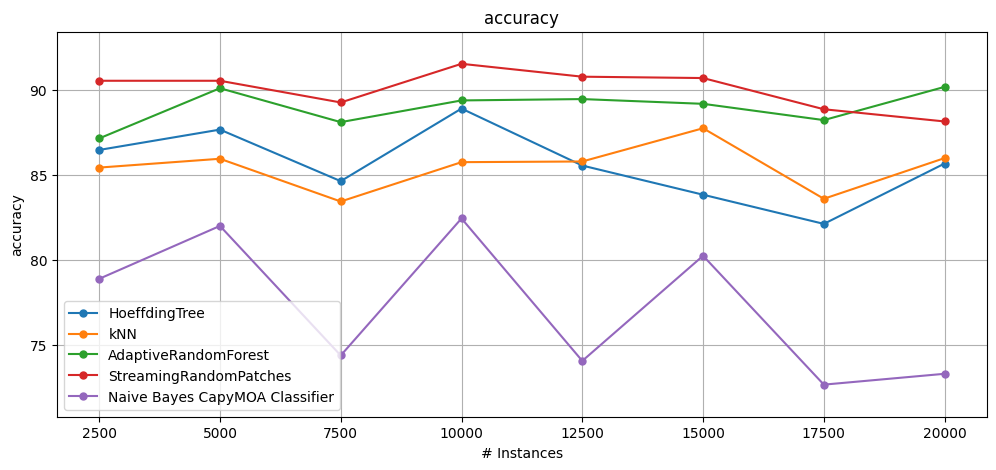

In [ ]:
# Code to select the best performing model
schema = stream.get_schema()
# schema = drift_stream2.get_schema()
ht = HoeffdingTree(schema)
knn = KNN(schema)
arf = AdaptiveRandomForestClassifier(schema, ensemble_size=5)
srp = StreamingRandomPatches(schema, ensemble_size=5)
nb = NaiveBayes(schema)
model_list = [ht, knn, arf, srp, nb]

all_res = stream_learning_model_selection(model_list, window_size, max_instances)
plot_windowed_results(*all_res.values(), metric="accuracy")

In [ ]:
from capymoa.evaluation import prequential_evaluation
from capymoa.automl import AutoClass

max_instances = 20000
window_size = 2500

schema = stream.get_schema()
autoclass = AutoClass(
    schema=schema,
    configuration_json="./settings_autoclass.json",
    base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree],
)
results_autoclass = prequential_evaluation(
    stream=stream,
    learner=autoclass,
    window_size=window_size,
    max_instances=max_instances,
)
print_summary("AutoClass", results_autoclass)

AutoClass  Cumulative accuracy = 88.31, wall-clock time: 33.038


HT         Cumulative accuracy = 85.61, wall-clock time: 0.118
HAT        Cumulative accuracy = 87.08, wall-clock time: 0.496
KNN        Cumulative accuracy = 85.47, wall-clock time: 2.793
NB         Cumulative accuracy = 77.23, wall-clock time: 0.102


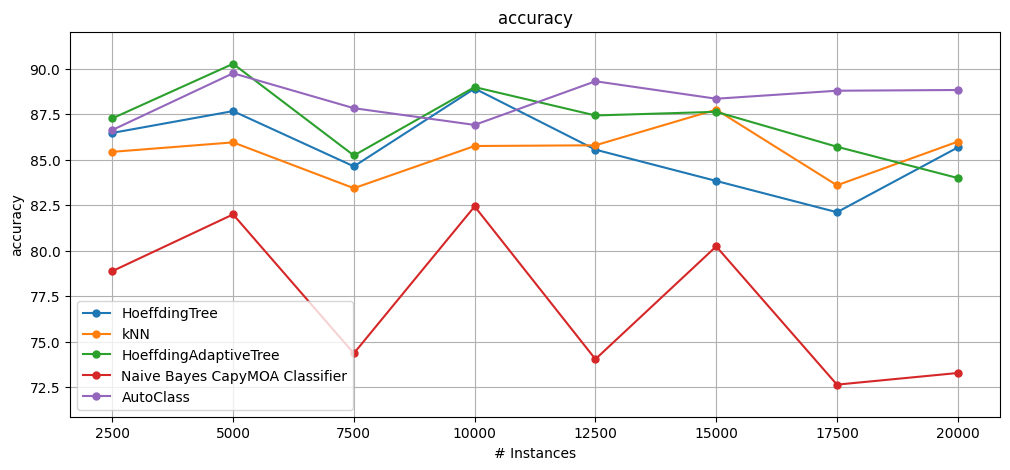

In [ ]:
ht = HoeffdingTree(schema)
hat = HoeffdingAdaptiveTree(schema)
knn = KNN(schema)
nb = NaiveBayes(schema)

results_ht = prequential_evaluation(
    stream, ht, window_size=window_size, max_instances=max_instances
)
results_hat = prequential_evaluation(
    stream, hat, window_size=window_size, max_instances=max_instances
)
results_knn = prequential_evaluation(
    stream, knn, window_size=window_size, max_instances=max_instances
)
results_nb = prequential_evaluation(
    stream, nb, window_size=window_size, max_instances=max_instances
)

print_summary("HT", results_ht)
print_summary("HAT", results_hat)
print_summary("KNN", results_knn)
print_summary("NB", results_nb)
plot_windowed_results(
    results_ht,
    results_knn,
    results_hat,
    results_nb,
    results_autoclass,
    metric="accuracy",
)

## Bnadit Classifier

In [21]:
import random

class EpsilonGreedy:
    """Epsilon-Greedy bandit policy for model selection.

    This policy selects the best model with probability 1-epsilon and explores
    other models with probability epsilon. During the burn-in period, it always
    explores to gather initial information about all models.

    Parameters
    ----------
    epsilon: float
        The probability of exploring a random model (default: 0.1)
    burn_in: int
        Number of initial rounds where all models are explored (default: 100)
    """

    def __init__(self, epsilon=0.1, burn_in=100):
        self.epsilon = epsilon
        self.burn_in = burn_in
        self.n_arms = 0
        self.arm_rewards = []
        self.arm_counts = []
        self.total_pulls = 0

    def initialize(self, n_arms):
        """Initialize the policy with a given number of arms."""
        self.n_arms = n_arms
        self.arm_rewards = [0.0] * n_arms
        self.arm_counts = [0] * n_arms
        self.total_pulls = 0

    def get_best_arm_idx(self, available_arms):
        best_arm = max(available_arms, key=lambda arm: self.arm_rewards[arm] / max(1, self.arm_counts[arm]))
        return best_arm


    def pull(self, available_arms):
        """Select which arms to pull based on the epsilon-greedy policy."""
        if self.total_pulls < self.burn_in:
            # During burn-in, explore all available arms
            return available_arms

        # With probability epsilon, explore a random arm
        if random.random() < self.epsilon:
            return [random.choice(available_arms)]

        # Otherwise, exploit the best arm
        best_arm = max(available_arms, key=lambda arm: self.arm_rewards[arm] / max(1, self.arm_counts[arm]))
        return [best_arm]

    def update(self, arm, reward):
        """Update the policy with the observed reward for the pulled arm."""
        self.arm_rewards[arm] += reward
        self.arm_counts[arm] += 1
        self.total_pulls += 1

    def get_arm_stats(self):
        """Get statistics about each arm's performance."""
        return {
            'rewards': self.arm_rewards.copy(),
            'counts': self.arm_counts.copy(),
            'means': [r / max(1, c) for r, c in zip(self.arm_rewards, self.arm_counts)]
        }

class BanditClassifier(Classifier):
    """Bandit-based model selection for classification in streaming scenarios.

    Each model is associated with an arm. At each train call, the policy decides which arm/model to pull.
    The reward is the performance of the model on the provided sample. The predict and predict_proba
    methods use the current best model.

    Parameters
    ----------
    schema: The stream schema
    base_classifiers: List of base classifier classes to consider
    config_file: Path to a JSON configuration file with model hyperparameters
    metric: The metric that is used to measure the performance of each model
    policy: The bandit policy to use (e.g., EpsilonGreedy, UCB, etc.)
    verbose: Whether to print progress information
    """

    def __init__(
        self,
        schema=None,
        random_seed=1,
        base_classifiers=None,
        config_file=None,
        metric="accuracy",
        policy=None,
        verbose=False
    ):
        super().__init__(schema=schema, random_seed=random_seed)

        self.config_file = config_file
        self.base_classifiers = base_classifiers
        self.metric = metric
        self.policy = policy
        self.verbose = verbose
        self.log_cnt = 0
        self.log_point = 5000

        # Initialize models based on configuration
        self._initialize_models()

        # Initialize policy if not provided
        if self.policy is None:
            self.policy = EpsilonGreedy(epsilon=0.1, burn_in=100)

        # Track the best model
        self._best_model_idx = 0

    def _initialize_models(self):
        """Initialize models based on configuration."""
        # Validate that we have at least one source of models
        if self.base_classifiers is None and self.config_file is None:
            raise ValueError("Either base_classifiers or config_file must be provided")

        # Initialize state variables
        self.active_models = []  # List of active model instances
        self.metrics = []  # List of evaluation metrics for each model

        # If using a config file, load and process it
        if self.config_file is not None:
            if self.verbose:
                print(f"Loading model configurations from {self.config_file}")
            self._load_model_configurations()
        else:
            # Use the provided base classifiers directly
            if self.verbose:
                print(f"Using {len(self.base_classifiers)} provided base classifiers")
            for model in self.base_classifiers:
                # Check if model is already instantiated or is a class
                if isinstance(model, Classifier):
                    # Model is already instantiated, use it directly
                    self.active_models.append(model)
                else:
                    # Model is a class, instantiate it
                    clf_instance = model(schema=self.schema)
                    self.active_models.append(clf_instance)

                # Create an evaluator for this model
                self.metrics.append(ClassificationEvaluator(schema=self.schema))

        # Initialize policy with number of arms
        self.policy.initialize(len(self.active_models))

    def _load_model_configurations(self):
        """Load model configurations from a JSON file."""
        try:
            with open(self.config_file, 'r') as f:
                config = json.load(f)

            # Process algorithms section of the config
            algorithms = config.get("algorithms", [])

            # If there are no algorithms defined, raise an error
            if not algorithms:
                raise ValueError("No algorithms defined in the configuration file")

            # Process each algorithm and its parameter configurations
            for algo_config in algorithms:
                algorithm_name = algo_config.get("algorithm")
                parameters = algo_config.get("parameters", [])

                # Generate all parameter combinations
                param_combinations = self._generate_parameter_combinations(parameters)

                # Create a classifier for each parameter combination
                for params in param_combinations:
                    try:
                        # Create classifier instance
                        clf = self._create_capymoa_classifier(algorithm_name, params)

                        if clf is not None:
                            self.active_models.append(clf)
                            self.metrics.append(ClassificationEvaluator(schema=self.schema))

                            if self.verbose:
                                param_str = ", ".join([f"{p['parameter']}={p['value']}" for p in params])
                                print(f"Added model: {algorithm_name} with parameters: {param_str}")
                    except Exception as e:
                        print(f"Warning: Failed to create model {algorithm_name} with parameters {params}: {str(e)}")

        except (json.JSONDecodeError, FileNotFoundError) as e:
            raise ValueError(f"Error loading configuration file: {str(e)}")

    def _create_capymoa_classifier(self, algorithm_name, params):
        """Create a CapyMOA classifier instance with the specified parameters."""
        # Map MOA class names to CapyMOA classifier classes
        moa_to_capymoa = {
            "moa.classifiers.meta.AdaptiveRandomForest": AdaptiveRandomForestClassifier,
            "moa.classifiers.trees.ExtremelyFastDecisionTree": EFDT,
            "moa.classifiers.trees.HoeffdingTree": HoeffdingTree,
            "moa.classifiers.bayes.NaiveBayes": NaiveBayes,
            "moa.classifiers.meta.OnlineBagging": OnlineBagging,
            "moa.classifiers.meta.OnlineBoosting": OnlineAdwinBagging,
            "moa.classifiers.meta.LeveragingBag": LeveragingBagging,
            "moa.classifiers.lazy.kNN": KNN,
            "moa.classifiers.functions.PassiveAggressive": PassiveAggressiveClassifier,
            "moa.classifiers.functions.SGD": SGDClassifier,
            "moa.classifiers.meta.StreamingGradientBoostedTrees": StreamingGradientBoostedTrees,
            "moa.classifiers.meta.OzaBoost": OzaBoost,
            "moa.classifiers.rules.MajorityClass": MajorityClass,
            "moa.classifiers.rules.NoChange": NoChange,
            "moa.classifiers.meta.OnlineSmoothBoost": OnlineSmoothBoost,
            "moa.classifiers.meta.StreamingRandomPatches": StreamingRandomPatches,
            "moa.classifiers.trees.HoeffdingAdaptiveTree": HoeffdingAdaptiveTree,
            "moa.classifiers.lazy.SAMkNN": SAMkNN,
            "moa.classifiers.meta.DynamicWeightedMajority": DynamicWeightedMajority,
            "moa.classifiers.meta.CSMOTE": CSMOTE,
            "moa.classifiers.lazy.WeightedkNN": WeightedkNN,
            "moa.classifiers.trees.Shrub": ShrubsClassifier
        }

        # Find matching classifier in CapyMOA
        if algorithm_name in moa_to_capymoa:
            clf_class = moa_to_capymoa[algorithm_name]
        else:
            # Try to find a matching classifier by the last part of the name
            classifier_name = algorithm_name.split('.')[-1]
            matching_class = None

            # Search for matching class by name
            for moa_name, capymoa_class in moa_to_capymoa.items():
                if moa_name.endswith(classifier_name):
                    matching_class = capymoa_class
                    break

            if matching_class is None:
                print(f"Warning: No matching CapyMOA classifier found for {algorithm_name}")
                return None

            clf_class = matching_class

        # Create an instance with the schema
        classifier = clf_class(schema=self.schema)

        # Set parameters on the classifier instance
        for param in params:
            param_name = param['parameter']
            param_value = param['value']

            try:
                # Try using setattr
                setattr(classifier, param_name, param_value)
            except (AttributeError, Exception) as e:
                # If setattr fails, try using a setter method
                try:
                    setter_name = f"set{param_name.capitalize()}"
                    if hasattr(classifier, setter_name):
                        setter = getattr(classifier, setter_name)
                        setter(param_value)
                    else:
                        print(f"Warning: Parameter '{param_name}' not found on {classifier.__class__.__name__}")
                except Exception as e:
                    print(f"Warning: Failed to set parameter '{param_name}' on {classifier.__class__.__name__}: {str(e)}")

        return classifier

    def _generate_parameter_combinations(self, parameters):
        """Generate all parameter combinations based on parameter ranges."""
        # Prepare parameter space
        param_space = []

        for param in parameters:
            param_name = param.get("parameter")
            param_type = param.get("type")
            param_range = param.get("range", [])

            # If a range is specified, create parameter values within that range
            if param_range and len(param_range) == 2:
                min_val, max_val = param_range

                # Generate values based on type
                if param_type == "integer":
                    # Take a few values across the range
                    num_values = min(5, max_val - min_val + 1)
                    step = max(1, (max_val - min_val) // (num_values - 1))
                    values = list(range(min_val, max_val + 1, step))
                elif param_type == "float":
                    # Take a few values across the range
                    num_values = 5
                    values = [min_val + (max_val - min_val) * i / (num_values - 1) for i in range(num_values)]
                else:
                    # Default to the provided value
                    values = [param.get("value")]
            else:
                # Use the single value provided
                values = [param.get("value")]

            # Add parameter and its values to parameter space
            param_configs = [{"parameter": param_name, "value": val} for val in values]
            param_space.append(param_configs)

        # Generate all combinations
        combinations = list(itertools.product(*param_space))
        return combinations

    def train(self, instance):
        """Train the selected model(s) on the given instance."""
        # Get the arm(s) to pull from the policy
        arm_ids = self.policy.pull(range(len(self.active_models)))

        # Train and evaluate each selected model
        for arm_id in arm_ids:
            model = self.active_models[arm_id]
            metric = self.metrics[arm_id]

            # Make prediction for evaluation before training
            y_pred = model.predict(instance)
            # Update metric with prediction
            metric.update(instance.y_index, y_pred)
            # Train the model
            model.train(instance)

            # Update the policy with the reward (metric value)
            reward = metric.accuracy() if self.metric == "accuracy" else metric.get()
            self.policy.update(arm_id, reward)

            # Check if this model is better than our current best
            if metric.accuracy() > self.metrics[self._best_model_idx].accuracy():
                self._best_model_idx = arm_id

            # Add verbose logging
        self.log_cnt += 1
        if self.verbose and self.log_cnt >= self.log_point:
            self.log_cnt = 0
            current_accuracy = metric.accuracy()
            model_performances = [(i, self.metrics[i].accuracy()) for i in arm_ids]
            top_models = sorted(model_performances, key=lambda x: x[1], reverse=True)[:3]

            print(f"\nChosen model: {model}")
            print(f"Current accuracy: {current_accuracy:.4f}")

            # Print top 3 models if there are many models
            if len(model_performances) >= 3:
                print("\nTop models:")
                for i, (model_idx, acc) in enumerate(top_models):
                    model_name = str(self.active_models[model_idx])
                    print(f"  {i+1}. {model_name} - Accuracy: {acc:.4f}")


    def predict(self, instance):
        """Predict the class label for the given instance using the best model."""
        if not self.active_models:
            raise ValueError("No active models available. Please train the classifier first.")
        idx = self.policy.get_best_arm_idx(range(len(self.active_models)))
        # Use the best performing model for predictions
        # idx = self._best_model_idx
        return self.active_models[idx].predict(instance)

    def predict_proba(self, instance):
        """Predict class probabilities for the given instance using the best model."""
        if not self.active_models:
            raise ValueError("No active models available. Please train the classifier first.")

        idx = self.policy.get_best_arm_idx(range(len(self.active_models)))
        # Use the best performing model for predictions
        # idx = self._best_model_idx
        return self.active_models[idx].predict_proba(instance)

    def __str__(self):
        """Return a string representation of the model."""
        return "BanditClassifier"

    @property
    def best_model(self):
        """Return the current best model."""
        idx = self.policy.get_best_arm_idx(range(len(self.active_models)))
        return self.active_models[idx]

    def get_model_info(self) -> Dict[str, Any]:
        """
        Get information about the current state of the classifier.

        Returns:
            Dictionary containing classifier information
        """
        # Get performance metrics for all models
        model_performances = {
            str(self.active_models[i]): self.metrics[i].accuracy()
            for i in range(len(self.active_models))
        }
        sorted_dict = dict(sorted(model_performances.items(), key=lambda item: item[1], reverse=True))
        # Get top-performing models
        top_models = []
        max_models = min(5, len(self.active_models))
        i = 0
        idx = self.policy.get_best_arm_idx(range(len(self.active_models)))
        for key, value in sorted_dict.items():
          if i >= max_models:
            break
          top_models.append({
                "model": key,
                "accuracy": value
          })
          i += 1
        # for i in range(min(5, len(self.active_models))):
        #     # top_models.append({
        #     #     "model": str(self.active_models[i]),
        #     #     "accuracy": self.metrics[i].accuracy()
        #     # })
        #       top_models.append({
        #         "model": str(self.active_models[i]),
        #         "accuracy": self.metrics[i].accuracy()
        #     })

        return {
            "total_models": len(self.active_models),
            "best_model_index": self._best_model_idx,
            "model_performances": sorted_dict,
            "best_model_accuracy": self.metrics[self._best_model_idx].accuracy() if self.metrics else None,
            "top_models": top_models
        }

## Successive Halving Classifier

In [9]:
"""
Successive Halving Classifier implementation for CapyMOA.

This module implements the Successive Halving algorithm for model selection in streaming data scenarios.
The algorithm progressively eliminates poorly performing models while allocating more resources to promising ones.

Successive halving is a method for performing model selection without having to train each model on all the dataset.
At certain points in time (called "rungs"), the worst performing models will be discarded and the best ones
will keep competing between each other. The rung values are designed so that at most 'budget' model updates
will be performed in total.
"""

# Import all classifier classes to be able to instantiate them by name
from capymoa.classifier import *

class SuccessiveHalvingClassifier(Classifier):
    """Successive Halving Classifier for model selection in streaming scenarios."""

    def __init__(
        self,
        schema=None,
        random_seed=1,
        base_classifiers=None,
        config_file=None,
        max_instances: int = None,
        budget: int = None,
        eta: float = 2.0,
        min_models: int = 1,
        evaluation_metric: str = "accuracy",
        verbose: bool = False
    ):
        """
        Initialize the Successive Halving Classifier.

        Args:
            schema: The stream schema
            random_seed: Random seed for reproducibility
            base_classifiers: List of base classifier classes to consider
            config_file: Path to a JSON configuration file with model hyperparameters
            max_instances: Maximum number of instances to process per model
                           (if provided, budget will be calculated as 2*n_models*max_instances/eta)
            budget: Total budget (number of training instances across all models)
                   (if max_instances is provided, this value will be ignored)
            eta: Reduction factor for the number of models in each round
            min_models: Minimum number of models to maintain
            evaluation_metric: Metric to use for model evaluation
            verbose: Whether to print progress information
        """
        super().__init__(schema=schema, random_seed=random_seed)

        self.config_file = config_file
        self.base_classifiers = base_classifiers
        self.max_instances = max_instances
        self.budget = budget
        self.eta = eta
        self.min_models = min_models
        self.evaluation_metric = evaluation_metric
        self.verbose = verbose

        # Initialize models based on configuration
        self._initialize_models()
        print(self.active_models)
        # Calculate budget if max_instances is provided
        if self.max_instances is not None:
            self.budget = math.ceil((2 * self._n * self.max_instances) / self.eta)
            if self.verbose:
                print(f"Budget automatically calculated: {self.budget} total updates")
                print(f"Formula: (2 * {self._n} models * {self.max_instances} instances) / {self.eta}")
        elif self.budget is None:
            # Default budget if neither max_instances nor budget is provided
            self.budget = 10000
            if self.verbose:
                print(f"Using default budget: {self.budget}")

        # Recalculate resource allocation based on final budget
        self._r = math.floor(self.budget / (self._s * math.ceil(math.log(max(2, self._n), self.eta))))

        # Track the best model
        self._best_model_idx = 0

    def _initialize_models(self):
        """Initialize models based on configuration."""
        # Validate that we have at least one source of models
        if self.base_classifiers is None and self.config_file is None:
            raise ValueError("Either base_classifiers or config_file must be provided")

        # Initialize state variables
        self.active_models = []  # List of active model instances
        self.metrics = []  # List of evaluation metrics for each model

        # If using a config file, load and process it
        if self.config_file is not None:
            if self.verbose:
                print(f"Loading model configurations from {self.config_file}")
            self._load_model_configurations()
        else:
            # Use the provided base classifiers directly
            if self.verbose:
                print(f"Using {len(self.base_classifiers)} provided base classifiers")
            for model in self.base_classifiers:
                # Check if model is already instantiated or is a class
                if isinstance(model, Classifier):
                    # Model is already instantiated, use it directly
                    self.active_models.append(model)
                else:
                    # Model is a class, instantiate it
                    clf_instance = model(schema=self.schema)
                    self.active_models.append(clf_instance)

                # Create an evaluator for this model
                self.metrics.append(ClassificationEvaluator(schema=self.schema))

        # Update state variables based on the total number of models
        self._n = len(self.active_models)  # Total number of models
        self._s = self._n  # Current number of active models
        self._n_rungs = 0  # Number of completed rungs
        self._iterations = 0  # Number of instances processed in current rung
        self._budget_used = 0  # Total budget used so far
        self._rankings = list(range(self._n))  # Current model rankings

    def _load_model_configurations(self):
        """Load model configurations from a JSON file."""
        try:
            with open(self.config_file, 'r') as f:
                config = json.load(f)

            # Process algorithms section of the config
            algorithms = config.get("algorithms", [])

            # If there are no algorithms defined, raise an error
            if not algorithms:
                raise ValueError("No algorithms defined in the configuration file")

            # Process each algorithm and its parameter configurations
            for algo_config in algorithms:
                algorithm_name = algo_config.get("algorithm")
                parameters = algo_config.get("parameters", [])

                # Generate all parameter combinations
                param_combinations = self._generate_parameter_combinations(parameters)

                # Create a classifier for each parameter combination
                for params in param_combinations:
                    try:
                        # Create classifier instance
                        clf = self._create_capymoa_classifier(algorithm_name, params)

                        if clf is not None:
                            self.active_models.append(clf)
                            self.metrics.append(ClassificationEvaluator(schema=self.schema))

                            if self.verbose:
                                param_str = ", ".join([f"{p['parameter']}={p['value']}" for p in params])
                                print(f"Added model: {algorithm_name} with parameters: {param_str}")
                    except Exception as e:
                        print(f"Warning: Failed to create model {algorithm_name} with parameters {params}: {str(e)}")

        except (json.JSONDecodeError, FileNotFoundError) as e:
            raise ValueError(f"Error loading configuration file: {str(e)}")

    def _create_capymoa_classifier(self, algorithm_name, params):
        """
        Create a CapyMOA classifier instance with the specified parameters.

        Args:
            algorithm_name: MOA algorithm name (e.g., "moa.classifiers.trees.HoeffdingTree")
            params: List of parameter dictionaries

        Returns:
            CapyMOA classifier instance
        """
        # Map MOA class names to CapyMOA classifier classes
        # moa_to_capymoa = {
        #     "moa.classifiers.trees.HoeffdingTree": HoeffdingTree,
        #     "moa.classifiers.bayes.NaiveBayes": NaiveBayes,
        #     "moa.classifiers.lazy.kNN": KNN,
        #     "moa.classifiers.meta.AdaptiveRandomForest": AdaptiveRandomForestClassifier,
        #     "moa.classifiers.trees.HoeffdingAdaptiveTree": HoeffdingAdaptiveTree,
        #     "moa.classifiers.meta.OnlineBagging": OnlineBagging
        # }


        moa_to_capymoa = {
            "moa.classifiers.meta.AdaptiveRandomForest": AdaptiveRandomForestClassifier,
            "moa.classifiers.trees.ExtremelyFastDecisionTree": EFDT,
            "moa.classifiers.trees.HoeffdingTree": HoeffdingTree,
            "moa.classifiers.bayes.NaiveBayes": NaiveBayes,
            "moa.classifiers.meta.OnlineBagging": OnlineBagging,
            "moa.classifiers.meta.OnlineBoosting": OnlineAdwinBagging,
            "moa.classifiers.meta.LeveragingBag": LeveragingBagging,
            "moa.classifiers.lazy.kNN": KNN,
            "moa.classifiers.functions.PassiveAggressive": PassiveAggressiveClassifier,
            "moa.classifiers.functions.SGD": SGDClassifier,
            "moa.classifiers.meta.StreamingGradientBoostedTrees": StreamingGradientBoostedTrees,
            "moa.classifiers.meta.OzaBoost": OzaBoost,
            "moa.classifiers.rules.MajorityClass": MajorityClass,
            "moa.classifiers.rules.NoChange": NoChange,
            "moa.classifiers.meta.OnlineSmoothBoost": OnlineSmoothBoost,
            "moa.classifiers.meta.StreamingRandomPatches": StreamingRandomPatches,
            "moa.classifiers.trees.HoeffdingAdaptiveTree": HoeffdingAdaptiveTree,
            "moa.classifiers.lazy.SAMkNN": SAMkNN,
            "moa.classifiers.meta.DynamicWeightedMajority": DynamicWeightedMajority,
            "moa.classifiers.meta.CSMOTE": CSMOTE,
            "moa.classifiers.lazy.WeightedkNN": WeightedkNN,
            "moa.classifiers.trees.Shrub": ShrubsClassifier
        }
        # Find matching classifier in CapyMOA
        # First try exact match, then try partial match
        if algorithm_name in moa_to_capymoa:
            clf_class = moa_to_capymoa[algorithm_name]
        else:
            # Try to find a matching classifier by the last part of the name
            classifier_name = algorithm_name.split('.')[-1]
            matching_class = None

            # Search for matching class by name
            for moa_name, capymoa_class in moa_to_capymoa.items():
                if moa_name.endswith(classifier_name):
                    matching_class = capymoa_class
                    break

            if matching_class is None:
                print(f"Warning: No matching CapyMOA classifier found for {algorithm_name}")
                return None

            clf_class = matching_class

        # Create an instance with the schema
        classifier = clf_class(schema=self.schema)

        # Set parameters on the classifier instance
        for param in params:
            param_name = param['parameter']
            param_value = param['value']

            try:
                # Try using setattr
                setattr(classifier, param_name, param_value)
            except (AttributeError, Exception) as e:
                # If setattr fails, try using a setter method
                try:
                    setter_name = f"set{param_name.capitalize()}"
                    if hasattr(classifier, setter_name):
                        setter = getattr(classifier, setter_name)
                        setter(param_value)
                    else:
                        print(f"Warning: Parameter '{param_name}' not found on {classifier.__class__.__name__}")
                except Exception as e:
                    print(f"Warning: Failed to set parameter '{param_name}' on {classifier.__class__.__name__}: {str(e)}")

        return classifier

    def _generate_parameter_combinations(self, parameters):
        """Generate all parameter combinations based on parameter ranges."""
        # Prepare parameter space
        param_space = []

        for param in parameters:
            param_name = param.get("parameter")
            param_type = param.get("type")
            param_range = param.get("range", [])

            # If a range is specified, create parameter values within that range
            if param_range and len(param_range) == 2:
                min_val, max_val = param_range

                # Generate values based on type
                if param_type == "integer":
                    # Take a few values across the range
                    num_values = min(5, max_val - min_val + 1)
                    step = max(1, (max_val - min_val) // (num_values - 1))
                    values = list(range(min_val, max_val + 1, step))
                elif param_type == "float":
                    # Take a few values across the range
                    num_values = 5
                    values = [min_val + (max_val - min_val) * i / (num_values - 1) for i in range(num_values)]
                else:
                    # Default to the provided value
                    values = [param.get("value")]
            else:
                # Use the single value provided
                values = [param.get("value")]

            # Add parameter and its values to parameter space
            param_configs = [{"parameter": param_name, "value": val} for val in values]
            param_space.append(param_configs)

        # Generate all combinations
        combinations = list(itertools.product(*param_space))
        return combinations

    def train(self, instance):
        # Train only active models
        for i in self._rankings[:self._s]:
            model = self.active_models[i]
            metric = self.metrics[i]

            # Make prediction for evaluation before training
            y_pred = model.predict(instance)
            # Update metric with prediction
            metric.update(instance.y_index, y_pred)
            # Train the model
            model.train(instance)

            # Check if this model is better than our current best
            if metric.accuracy() > self.metrics[self._best_model_idx].accuracy():
                self._best_model_idx = i

        # Increment iteration counter
        self._iterations += 1

        # Check if we've completed a rung and have more than one model
        if self._s > self.min_models and self._iterations >= self._r:
            # Increment rung counter
            self._n_rungs += 1
            # Update budget used
            self._budget_used += self._s * self._r

            # Rank models by their performance
            self._rankings[:self._s] = sorted(
                self._rankings[:self._s],
                key=lambda i: self.metrics[i].accuracy(),
                reverse=True  # Higher accuracy is better
            )

            # self._best_model_idx = self._rankings[0]

            # Determine how many models to keep
            cutoff = max(self.min_models, math.ceil(self._s / self.eta))

            # Print status if verbose
            if self.verbose:
                best_score = self.metrics[self._rankings[0]].accuracy()
                print(
                    "\t".join(
                        (
                            f"[Rung {self._n_rungs}]",
                            f"{self._s - cutoff} models removed",
                            f"{cutoff} models left",
                            f"{self._r} instances per model",
                            f"budget used: {self._budget_used}",
                            f"budget left: {self.budget - self._budget_used}",
                            f"best accuracy: {best_score:.4f}",
                        )
                    )
                )

                # Show the top 3 models if there are many
                if self._s > 3:
                    print("Top models:")
                    for i, idx in enumerate(self._rankings[:min(3, cutoff)]):
                        model = self.active_models[idx]
                        accuracy = self.metrics[idx].accuracy()
                        print(f"  {i+1}. {model} - Accuracy: {accuracy:.4f}")

            # Update the number of active models
            self._s = cutoff

            # Recalculate the number of instances for the next rung
            remaining_rungs = max(1, math.ceil(math.log(self._n, self.eta)) - self._n_rungs)
            self._r = math.floor(
                (self.budget - self._budget_used) /
                (self._s * remaining_rungs)
            )

            # Reset iteration counter for the next rung
            self._iterations = 0

    def predict(self, instance):
        if not self.active_models:
            raise ValueError("No active models available. Please train the classifier first.")

        # Use the best performing model for predictions
        return self.active_models[self._best_model_idx].predict(instance)

    def predict_proba(self, instance):
        if not self.active_models:
            raise ValueError("No active models available. Please train the classifier first.")

        # Use the best performing model for predictions
        return self.active_models[self._best_model_idx].predict_proba(instance)

    def __str__(self):
        """Return a string representation of the model."""
        return "SuccessiveHalvingClassifier"

    @property
    def best_model(self):
        """Return the current best model."""
        return self.active_models[self._best_model_idx]

    def get_model_info(self) -> Dict[str, Any]:
        """
        Get information about the current state of the classifier.

        Returns:
            Dictionary containing classifier information
        """
        # Calculate active models based on rankings
        active_models = [self.active_models[i] for i in self._rankings[:self._s]]
        # Get performance metrics for all models
        model_performances = {
            str(self.active_models[i]): self.metrics[i].accuracy()
            for i in range(len(self.active_models))
        }

        # Get top-performing models
        top_models = []
        for i in range(min(5, self._s)):
            if i < len(self._rankings):
                idx = self._rankings[i]
                top_models.append({
                    "model": str(self.active_models[idx]),
                    "accuracy": self.metrics[idx].accuracy()
                })

        return {
            "active_models": self._s,
            "total_models": self._n,
            "current_rung": self._n_rungs,
            "max_instances": self.max_instances,
            "total_budget": self.budget,
            "budget_used": self._budget_used,
            "budget_left": self.budget - self._budget_used,
            "iterations_in_current_rung": self._iterations,
            "best_model_index": self._best_model_idx,
            "model_performances": model_performances,
            "best_model_accuracy": self.metrics[self._best_model_idx].accuracy() if self.metrics else None,
            "top_models": top_models
        }

## Comparing differnet models with SuccessiveHalvingClassifer and Bandit Classifier

In [10]:
def test_base_classifiers(stream, max_instances=20000, window_size=2500, bandit_eps=0.3):
    """Test the base_classifiers parameter of SuccessiveHalvingClassifier and BanditClassifier."""
    print("\n" + "="*80)
    print("TESTING SUCCESSIVE HALVING AND BANDIT CLASSIFIERS WITH DIRECT BASE_CLASSIFIERS")
    print("="*80)

    schema = stream.get_schema()

    # Create base classifiers with different hyperparameters
    base_models = []

    # Add Hoeffding Trees with different hyperparameters (reduced configurations)
    for grace_period in [100, 200]:
        for confidence in [0.01, 0.1]:
            base_models.append(HoeffdingTree(schema=schema, grace_period=grace_period, confidence=confidence))

    # Add KNN variations (reduced configurations)
    for k in [3, 10]:
        base_models.append(KNN(schema=schema, k=k))

    # Add Naive Bayes
    base_models.append(NaiveBayes(schema=schema))

    # Add Random Forest models (reduced configurations)
    for ensemble_size in [80, 100, 120]:
        base_models.append(AdaptiveRandomForestClassifier(schema=schema, ensemble_size=ensemble_size))

    # Add Hoeffding Adaptive Trees (reduced configurations)
    for grace_period in [100, 200]:
        base_models.append(HoeffdingAdaptiveTree(schema=schema, grace_period=grace_period))

    # Add one instance of each other model type
    base_models.append(LeveragingBagging(schema=schema, ensemble_size=80))
    base_models.append(StreamingRandomPatches(schema=schema, ensemble_size=80))
    base_models.append(SGDClassifier(schema=schema))
    base_models.append(PassiveAggressiveClassifier(schema=schema))

    print(f"Total number of model configurations: {len(base_models)}")

    # Create the SuccessiveHalvingClassifier with direct specification of base classifiers
    shc_direct = SuccessiveHalvingClassifier(
        schema=schema,
        base_classifiers=base_models,
        budget=max_instances*3,
        eta=2.0,
        min_models=2,
        verbose=True
    )

    # Create the BanditClassifier with the same base classifiers
    bandit_clf = BanditClassifier(
        schema=schema,
        base_classifiers=base_models,
        metric="accuracy",
        policy=EpsilonGreedy(epsilon=bandit_eps, burn_in=150),
        verbose=True
    )

    # Initialize default models for comparison
    print("\nInitializing default models for comparison...")
    default_ht = HoeffdingTree(schema=schema)
    default_nb = NaiveBayes(schema=schema)
    default_knn = KNN(schema=schema)
    default_arf = AdaptiveRandomForestClassifier(schema=schema)
    default_hat = HoeffdingAdaptiveTree(schema=schema)
    default_lb = LeveragingBagging(schema=schema)
    default_srp = StreamingRandomPatches(schema=schema)
    default_sgd = SGDClassifier(schema=schema)
    default_pa = PassiveAggressiveClassifier(schema=schema)

    autoclass = AutoClass(
        schema=schema,
        configuration_json="./settings_autoclass.json",
        base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree],
    )

    print("\nRunning prequential evaluation...")
    results_shc_direct = prequential_evaluation(
        stream=stream,
        learner=shc_direct,
        window_size=window_size,
        max_instances=max_instances
    )

    results_bandit = prequential_evaluation(
        stream=stream,
        learner=bandit_clf,
        window_size=window_size,
        max_instances=max_instances
    )

    # Evaluate default models
    print("\nEvaluating default models...")
    results_ht = prequential_evaluation(
        stream=stream,
        learner=default_ht,
        window_size=window_size,
        max_instances=max_instances
    )

    results_nb = prequential_evaluation(
        stream=stream,
        learner=default_nb,
        window_size=window_size,
        max_instances=max_instances
    )

    results_knn = prequential_evaluation(
        stream=stream,
        learner=default_knn,
        window_size=window_size,
        max_instances=max_instances
    )

    results_arf = prequential_evaluation(
        stream=stream,
        learner=default_arf,
        window_size=window_size,
        max_instances=max_instances
    )

    results_hat = prequential_evaluation(
        stream=stream,
        learner=default_hat,
        window_size=window_size,
        max_instances=max_instances
    )

    results_lb = prequential_evaluation(
        stream=stream,
        learner=default_lb,
        window_size=window_size,
        max_instances=max_instances
    )

    results_srp = prequential_evaluation(
        stream=stream,
        learner=default_srp,
        window_size=window_size,
        max_instances=max_instances
    )

    results_sgd = prequential_evaluation(
        stream=stream,
        learner=default_sgd,
        window_size=window_size,
        max_instances=max_instances
    )

    results_pa = prequential_evaluation(
        stream=stream,
        learner=default_pa,
        window_size=window_size,
        max_instances=max_instances
    )

    results_autoclass = prequential_evaluation(
        stream=stream,
        learner=autoclass,
        window_size=window_size,
        max_instances=max_instances,
    )

    # Print results
    print("\nEvaluation Results:")
    print(f"[Successive Halving with {len(base_models)} base models] Accuracy = {results_shc_direct.accuracy():.3f}, "
          f"Time: {results_shc_direct.wallclock():.3f}s")
    print(f"[Bandit Classifier with {len(base_models)} base models] Accuracy = {results_bandit.accuracy():.3f}, "
          f"Time: {results_bandit.wallclock():.3f}s")
    print(f"[AutoClass] Accuracy = {results_autoclass.accuracy():.3f}, "
          f"Time: {results_autoclass.wallclock():.3f}s")
    print(f"[Default Hoeffding Tree] Accuracy = {results_ht.accuracy():.3f}, "
          f"Time: {results_ht.wallclock():.3f}s")
    print(f"[Default Naive Bayes] Accuracy = {results_nb.accuracy():.3f}, "
          f"Time: {results_nb.wallclock():.3f}s")
    print(f"[Default KNN] Accuracy = {results_knn.accuracy():.3f}, "
          f"Time: {results_knn.wallclock():.3f}s")
    print(f"[Default Adaptive Random Forest] Accuracy = {results_arf.accuracy():.3f}, "
          f"Time: {results_arf.wallclock():.3f}s")
    print(f"[Default Hoeffding Adaptive Tree] Accuracy = {results_hat.accuracy():.3f}, "
          f"Time: {results_hat.wallclock():.3f}s")
    print(f"[Default Leverage Bagging] Accuracy = {results_lb.accuracy():.3f}, "
          f"Time: {results_lb.wallclock():.3f}s")
    print(f"[Default Streaming Random Patches] Accuracy = {results_srp.accuracy():.3f}, "
          f"Time: {results_srp.wallclock():.3f}s")

    # Plot results
    print("\nPlotting windowed results...")
    plot_windowed_results(
        results_shc_direct, results_bandit, results_autoclass, results_ht, results_nb,
        results_knn, results_arf, results_hat, results_lb, results_srp, results_sgd,
        results_pa, metric="accuracy"
    )

    # Display final model info for SuccessiveHalving
    model_info_shc = shc_direct.get_model_info()
    print("\nSuccessive Halving Final Status:")
    print(f"Active models: {model_info_shc['active_models']} / {model_info_shc['total_models']}")
    print(f"Total rungs: {model_info_shc['current_rung']}")
    print(f"Budget used: {model_info_shc['budget_used']} / {model_info_shc['total_budget']}")
    print(f"Best model accuracy: {model_info_shc['best_model_accuracy']:.4f}")

    # # Display final model info for BanditClassifier
    # model_info_bandit = bandit_clf.get_model_info()
    # print("\nBandit Classifier Final Status:")
    # print(f"Total models: {model_info_bandit['total_models']}")
    # print(f"Best model accuracy: {model_info_bandit['best_model_accuracy']:.4f}")
    # print("\nTop performing models in BanditClassifier:")
    # for i, model_info in enumerate(model_info_bandit['top_models']):
    #     print(f"  {i+1}. {model_info['model']} - Accuracy: {model_info['accuracy']:.4f}")

    return (results_shc_direct, results_bandit, results_autoclass, results_ht,
            results_nb, results_knn, results_arf, results_hat, results_lb,
            results_srp, results_sgd, results_pa)

def test_successive_halving_parameter_tuning(stream, max_instances=20000, window_size=2500, budget=None, bandit_eps=0.1):
    """Test SuccessiveHalving and BanditClassifier for parameter optimization of a single model type."""
    print("\n" + "="*80)
    print("TESTING SUCCESSIVE HALVING AND BANDIT CLASSIFIER FOR PARAMETER OPTIMIZATION")
    print("="*80)

    schema = stream.get_schema()
    if budget is None:
        budget = max_instances * 2

    # Create a wide range of HoeffdingTree configurations with different parameters
    ht_models = []

    # Test different grace periods
    for grace_period in [50, 100, 200, 300, 400]:
        # Test different split confidences
        for confidence in [0.001, 0.01, 0.05, 0.1, 0.2]:
            # Test different tie thresholds
            for tie_threshold in [0.05, 0.1, 0.2]:
                ht_models.append(HoeffdingTree(
                    schema=schema,
                    grace_period=grace_period,
                    confidence=confidence,
                    tie_threshold=tie_threshold
                ))

    print(f"Created {len(ht_models)} different HoeffdingTree configurations")

    # Use SuccessiveHalving to find the best HoeffdingTree configuration
    shc_ht = SuccessiveHalvingClassifier(
        schema=schema,
        base_classifiers=ht_models,
        budget=budget,
        eta=2.0,
        min_models=1,
        verbose=True
    )

    # Use BanditClassifier to find the best HoeffdingTree configuration
    bandit_ht = BanditClassifier(
        schema=schema,
        base_classifiers=ht_models,
        metric="accuracy",
        policy=EpsilonGreedy(epsilon=bandit_eps, burn_in=150),
        verbose=True
    )

    # Default HoeffdingTree for comparison
    default_ht = HoeffdingTree(schema=schema)

    print("\nRunning prequential evaluation...")
    results_shc_ht = prequential_evaluation(
        stream=stream,
        learner=shc_ht,
        window_size=window_size,
        max_instances=max_instances
    )

    results_bandit_ht = prequential_evaluation(
        stream=stream,
        learner=bandit_ht,
        window_size=window_size,
        max_instances=max_instances
    )

    results_default_ht = prequential_evaluation(
        stream=stream,
        learner=default_ht,
        window_size=window_size,
        max_instances=max_instances
    )

    # Print results
    print("\nEvaluation Results:")
    print(f"[SuccessiveHalving with {len(ht_models)} HT configs] Accuracy = {results_shc_ht.accuracy():.3f}, "
          f"Time: {results_shc_ht.wallclock():.3f}s")
    print(f"[BanditClassifier with {len(ht_models)} HT configs] Accuracy = {results_bandit_ht.accuracy():.3f}, "
          f"Time: {results_bandit_ht.wallclock():.3f}s")
    print(f"[Default HoeffdingTree] Accuracy = {results_default_ht.accuracy():.3f}, "
          f"Time: {results_default_ht.wallclock():.3f}s")

    # Calculate improvements
    improvement_shc = (results_shc_ht.accuracy() - results_default_ht.accuracy())
    improvement_bandit = (results_bandit_ht.accuracy() - results_default_ht.accuracy())
    print(f"Improvement over default parameters:")
    print(f"  SuccessiveHalving: {improvement_shc:.2f}% absolute")
    print(f"  BanditClassifier: {improvement_bandit:.2f}% absolute")

    # Plot results
    plot_windowed_results(
        results_shc_ht, results_bandit_ht, results_default_ht,
        metric="accuracy"
    )

    # Display final model info
    model_info_shc = shc_ht.get_model_info()
    print("\nSuccessive Halving Final Status:")
    print(f"Active models: {model_info_shc['active_models']} / {model_info_shc['total_models']}")
    print(f"Total rungs: {model_info_shc['current_rung']}")
    print(f"Budget used: {model_info_shc['budget_used']} / {model_info_shc['total_budget']}")

    # model_info_bandit = bandit_ht.get_model_info()
    # print("\nBandit Classifier Final Status:")
    # print(f"Total models: {model_info_bandit['total_models']}")
    # print(f"Best model accuracy: {model_info_bandit['best_model_accuracy']:.4f}")

    return results_shc_ht, results_bandit_ht, results_default_ht, shc_ht, bandit_ht

def create_extended_autoclass_config():
    """Create an extended configuration for AutoClass with more models and parameters."""
    # Create the configuration similar to the models in test_base_classifiers
    enhanced_conf = {
        "ensembleSize": 10,
        "newConfigurations": 10,
        "keepCurrentModel": True,
        "lambda": 0.05,
        "preventAlgorithmDeath": True,
        "keepGlobalIncumbent": True,
        "keepAlgorithmIncumbents": True,
        "keepInitialConfigurations": True,
        "useTestEnsemble": True,
        "resetProbability": 0.01,
        "numberOfCores": 1,
        "performanceMeasureMaximisation": True,

        "algorithms": [
            {
                "algorithm": "moa.classifiers.trees.HoeffdingTree",
                "parameters": [
                    {"parameter": "g", "type": "integer", "value": 200, "range": [100, 400]},
                    {"parameter": "c", "type": "float", "value": 0.01, "range": [0.001, 0.1]}
                ]
            },
            {
                "algorithm": "moa.classifiers.lazy.kNN",
                "parameters": [
                    {"parameter": "k", "type": "integer", "value": 10, "range": [3, 20]}
                ]
            },
            # {
            #     "algorithm": "moa.classifiers.bayes.NaiveBayes",
            #     "parameters": []
            # },
            {
                "algorithm": "moa.classifiers.meta.AdaptiveRandomForest",
                "parameters": [
                    {"parameter": "s", "type": "integer", "value": 100, "range": [80, 120]}
                ]
            },
            {
                "algorithm": "moa.classifiers.trees.HoeffdingAdaptiveTree",
                "parameters": [
                    {"parameter": "g", "type": "integer", "value": 200, "range": [100, 300]}
                ]
            },
            {
                "algorithm": "moa.classifiers.meta.LeveragingBag",
                "parameters": [
                    {"parameter": "s", "type": "integer", "value": 80, "range": [60, 100]}
                ]
            },
            {
                "algorithm": "moa.classifiers.meta.StreamingRandomPatches",
                "parameters": [
                    {"parameter": "s", "type": "integer", "value": 80, "range": [60, 100]}
                ]
            },
            # {
            #     "algorithm": "moa.classifiers.functions.SGD",
            #     "parameters": []
            # },
            # {
            #     "algorithm": "moa.classifiers.functions.PassiveAggressive",
            #     "parameters": []
            # }
        ]
    }

    # Save the configuration to a file
    with open('enhanced_autoclass_config.json', 'w') as fp:
        json.dump(enhanced_conf, fp)

    print("Enhanced AutoClass configuration saved to 'enhanced_autoclass_config.json'")
    return 'enhanced_autoclass_config.json'

def test_autoclass_vs_successive_halving(stream, max_instances=20000, window_size=2500, budget=None, bandit_eps=0.1):
    """Compare AutoClass with enhanced configuration against SuccessiveHalvingClassifier and BanditClassifier."""
    print("\n" + "="*80)
    print("COMPARING AUTOCLASS WITH CONFIG, SUCCESSIVE HALVING, AND BANDIT CLASSIFIER")
    print("="*80)

    schema = stream.get_schema()
    if budget is None:
        budget = max_instances * 3

    # Create the enhanced configuration for AutoClass
    enhanced_config_file = create_extended_autoclass_config()

    # Initialize AutoClass with the enhanced configuration
    autoclass_enhanced = AutoClass(
        schema=schema,
        configuration_json=enhanced_config_file,
        base_classifiers=[KNN, HoeffdingTree, HoeffdingAdaptiveTree, AdaptiveRandomForestClassifier,
                         LeveragingBagging, StreamingRandomPatches]
    )

    # Create base classifiers with same parameters for SuccessiveHalving and BanditClassifier
    base_models = []

    # Add Hoeffding Trees
    for grace_period in [100, 200, 300, 400]:
        for confidence in [0.001, 0.01, 0.05, 0.1]:
            base_models.append(HoeffdingTree(schema=schema, grace_period=grace_period, confidence=confidence))

    # Add KNN variations
    for k in [3, 5, 10, 15, 20]:
        base_models.append(KNN(schema=schema, k=k))

    # Add Random Forest models
    for ensemble_size in [80, 100, 120]:
        base_models.append(AdaptiveRandomForestClassifier(schema=schema, ensemble_size=ensemble_size))

    # Add Hoeffding Adaptive Trees
    for grace_period in [100, 200, 300]:
        base_models.append(HoeffdingAdaptiveTree(schema=schema, grace_period=grace_period))

    # Add Leveraging Bagging models
    for ensemble_size in [60, 80, 100]:
        base_models.append(LeveragingBagging(schema=schema, ensemble_size=ensemble_size))

    # Add Streaming Random Patches
    for ensemble_size in [60, 80, 100]:
        base_models.append(StreamingRandomPatches(schema=schema, ensemble_size=ensemble_size))

    print(f"Total number of model configurations: {len(base_models)}")

    # Create the SuccessiveHalvingClassifier
    shc_direct = SuccessiveHalvingClassifier(
        schema=schema,
        base_classifiers=base_models,
        budget=budget,
        eta=2.0,
        min_models=2,
        verbose=True
    )

    # Create the BanditClassifier
    bandit_clf = BanditClassifier(
        schema=schema,
        base_classifiers=base_models,
        metric="accuracy",
        policy=EpsilonGreedy(epsilon=bandit_eps, burn_in=150),
        verbose=True
    )

    # Initialize default models for comparison
    print("\nInitializing default models for comparison...")
    default_ht = HoeffdingTree(schema=schema)
    default_knn = KNN(schema=schema)
    default_arf = AdaptiveRandomForestClassifier(schema=schema)
    default_hat = HoeffdingAdaptiveTree(schema=schema)
    default_lb = LeveragingBagging(schema=schema)
    default_srp = StreamingRandomPatches(schema=schema)

    print("\nRunning prequential evaluation...")

    # Evaluate all approaches
    results_autoclass_enhanced = prequential_evaluation(
        stream=stream,
        learner=autoclass_enhanced,
        window_size=window_size,
        max_instances=max_instances
    )

    results_shc = prequential_evaluation(
        stream=stream,
        learner=shc_direct,
        window_size=window_size,
        max_instances=max_instances
    )

    results_bandit = prequential_evaluation(
        stream=stream,
        learner=bandit_clf,
        window_size=window_size,
        max_instances=max_instances
    )

    # Evaluate default models
    print("\nEvaluating default models...")
    results_ht = prequential_evaluation(
        stream=stream,
        learner=default_ht,
        window_size=window_size,
        max_instances=max_instances
    )

    results_knn = prequential_evaluation(
        stream=stream,
        learner=default_knn,
        window_size=window_size,
        max_instances=max_instances
    )

    results_arf = prequential_evaluation(
        stream=stream,
        learner=default_arf,
        window_size=window_size,
        max_instances=max_instances
    )

    results_hat = prequential_evaluation(
        stream=stream,
        learner=default_hat,
        window_size=window_size,
        max_instances=max_instances
    )

    results_lb = prequential_evaluation(
        stream=stream,
        learner=default_lb,
        window_size=window_size,
        max_instances=max_instances
    )

    results_srp = prequential_evaluation(
        stream=stream,
        learner=default_srp,
        window_size=window_size,
        max_instances=max_instances
    )

    # Print results
    print("\nEvaluation Results:")
    print(f"[Enhanced AutoClass] Accuracy = {results_autoclass_enhanced.accuracy():.3f}, "
          f"Time: {results_autoclass_enhanced.wallclock():.3f}s")
    print(f"[SuccessiveHalving] Accuracy = {results_shc.accuracy():.3f}, "
          f"Time: {results_shc.wallclock():.3f}s")
    print(f"[BanditClassifier] Accuracy = {results_bandit.accuracy():.3f}, "
          f"Time: {results_bandit.wallclock():.3f}s")
    print(f"[Default HoeffdingTree] Accuracy = {results_ht.accuracy():.3f}, "
          f"Time: {results_ht.wallclock():.3f}s")
    print(f"[Default KNN] Accuracy = {results_knn.accuracy():.3f}, "
          f"Time: {results_knn.wallclock():.3f}s")
    print(f"[Default AdaptiveRandomForest] Accuracy = {results_arf.accuracy():.3f}, "
          f"Time: {results_arf.wallclock():.3f}s")
    print(f"[Default HoeffdingAdaptiveTree] Accuracy = {results_hat.accuracy():.3f}, "
          f"Time: {results_hat.wallclock():.3f}s")
    print(f"[Default LeveragingBagging] Accuracy = {results_lb.accuracy():.3f}, "
          f"Time: {results_lb.wallclock():.3f}s")
    print(f"[Default StreamingRandomPatches] Accuracy = {results_srp.accuracy():.3f}, "
          f"Time: {results_srp.wallclock():.3f}s")

    # Plot results
    plot_windowed_results(
        results_autoclass_enhanced, results_shc, results_bandit, results_ht,
        results_knn, results_arf, results_hat, results_lb, results_srp,
        metric="accuracy"
    )

    # Display final model info for SuccessiveHalving
    model_info_shc = shc_direct.get_model_info()
    print("\nSuccessive Halving Final Status:")
    print(f"Active models: {model_info_shc['active_models']} / {model_info_shc['total_models']}")
    print(f"Total rungs: {model_info_shc['current_rung']}")
    print(f"Budget used: {model_info_shc['budget_used']} / {model_info_shc['total_budget']}")

    # Display final model info for BanditClassifier
    model_info_bandit = bandit_clf.get_model_info()
    print("\nBandit Classifier Final Status:")
    print(f"Total models: {model_info_bandit['total_models']}")
    print(f"Best model accuracy: {model_info_bandit['best_model_accuracy']:.4f}")

    print("\nTop performing models:")
    print("SuccessiveHalving:")
    for i, model_info in enumerate(model_info_shc['top_models']):
        print(f"  {i+1}. {model_info['model']} - Accuracy: {model_info['accuracy']:.4f}")

    # print("\nBanditClassifier:")
    # for i, model_info in enumerate(model_info_bandit['top_models']):
    #     print(f"  {i+1}. {model_info['model']} - Accuracy: {model_info['accuracy']:.4f}")

    return (results_autoclass_enhanced, results_shc, results_bandit, results_ht,
            results_knn, results_arf, results_hat, results_lb, results_srp)

#### Testing whether SuccessiveHalvingClassifier and BanditClassifier work correctly


TESTING SUCCESSIVE HALVING AND BANDIT CLASSIFIER FOR PARAMETER OPTIMIZATION
Created 75 different HoeffdingTree configurations
Using 75 provided base classifiers
[<capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e76db65350>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e770eedc50>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e76daf5590>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e770c9c290>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e770c9e690>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e770c9c4d0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e770c9d010>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e76dab9a50>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e76dab8610>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e770c9c050>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e76

(<capymoa.evaluation.results.PrequentialResults at 0x78e7673552d0>,
 <__main__.BanditClassifier at 0x78e770e2acd0>)

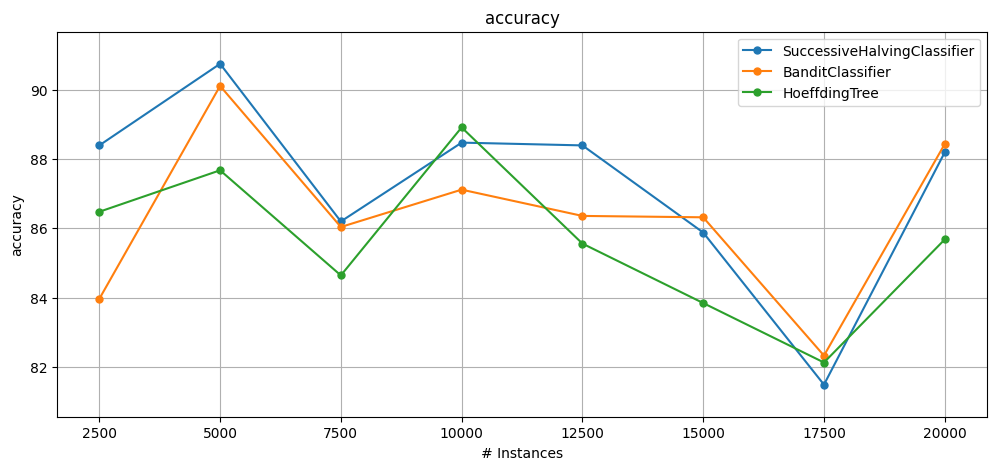

In [22]:
stream = Electricity()
max_instances = 20000
window_size = 2500
budget=max_instances*2
test_successive_halving_parameter_tuning(stream, max_instances=max_instances, window_size=window_size, budget=budget)

The initial test demonstrates that both SuccessiveHalvingClassifier and BanditClassifier work correctly for parameter optimization.

SuccessiveHalvingClassifier achieves the highest accuracy at 87.225%, showing a substantial 1.61% absolute improvement over the default HoeffdingTree. However, this comes at a computational cost of 153.404s. BanditClassifier offers a middle ground, reaching 85.630% accuracy (only 0.02% above default) while requiring significantly less time (85.613s), making it approximately 44% faster than SuccessiveHalvingClassifier.

The accuracy-time trade-off is clear: SuccessiveHalvingClassifier invests more computational resources to thoroughly evaluate configurations, while BanditClassifier makes quicker decisions that sacrifice some accuracy for substantial time savings.

#### Electricity Stream


COMPARING AUTOCLASS WITH CONFIG, SUCCESSIVE HALVING, AND BANDIT CLASSIFIER
Enhanced AutoClass configuration saved to 'enhanced_autoclass_config.json'
Total number of model configurations: 33
Using 33 provided base classifiers
[<capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e770dac0d0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e76dc80e50>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e770c93650>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e770eef310>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e76eca6a10>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e770eedcd0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e76db25710>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e767896a90>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e76ec75790>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e771044290>, <c

(<capymoa.evaluation.results.PrequentialResults at 0x78e76715f790>,
 <capymoa.evaluation.results.PrequentialResults at 0x78e76715c410>)

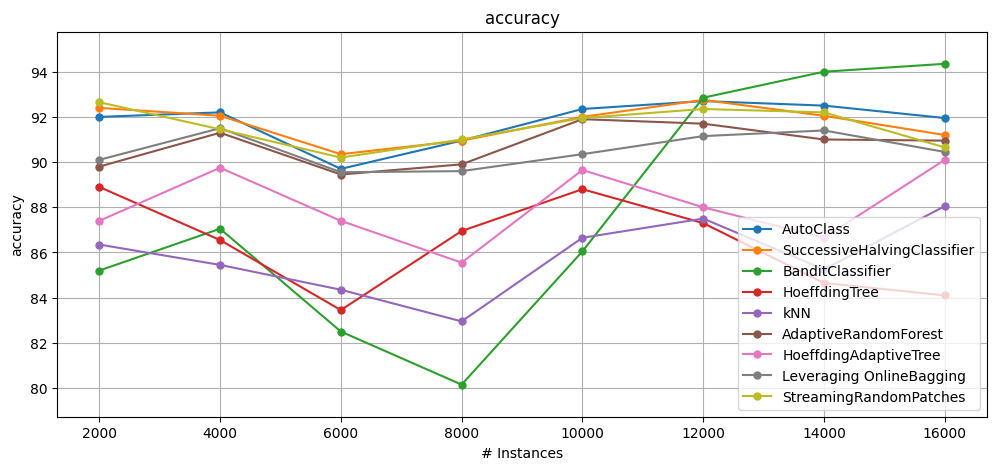

In [23]:
stream = Electricity()
max_instances = 15000
window_size = 2000
budget=max_instances
test_autoclass_vs_successive_halving(stream, window_size=window_size, max_instances=max_instances, budget=budget, bandit_eps=0.3)

On the Electricity dataset, Enhanced AutoClass demonstrates superior accuracy at 91.833%, closely followed by SuccessiveHalvingClassifier at 91.600%. BanditClassifier significantly underperforms with 84.493% accuracy, falling behind even the default HoeffdingTree (86.187%). Regarding computational efficiency, BanditClassifier completes in just 75.419s, compared to 264.252s for SuccessiveHalvingClassifier and 438.069s for Enhanced AutoClass. This represents a stark trade-off where BanditClassifier runs 5.8x faster than AutoClass but sacrifices 7.34% in accuracy.

SuccessiveHalvingClassifier provides an excellent balance, achieving nearly identical accuracy to AutoClass while requiring 40% less time. For this stream, SuccessiveHalvingClassifier clearly outperforms BanditClassifier in the accuracy-efficiency trade-off, suggesting that more thorough configuration exploration is beneficial for this particular data pattern. Both model selection approaches outperform individual default models, except for BanditClassifier which falls behind several default options.

#### RBFm_100k Stream


COMPARING AUTOCLASS WITH CONFIG, SUCCESSIVE HALVING, AND BANDIT CLASSIFIER
Enhanced AutoClass configuration saved to 'enhanced_autoclass_config.json'
Total number of model configurations: 33
Using 33 provided base classifiers
[<capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e7671db2d0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e7671d8090>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e7671da750>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e7671d9890>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e7671d9150>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e767116b90>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e767117310>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e767116590>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e767116690>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e767117190>, <c

(<capymoa.evaluation.results.PrequentialResults at 0x78e770cb4c10>,
 <capymoa.evaluation.results.PrequentialResults at 0x78e7673e1f10>)

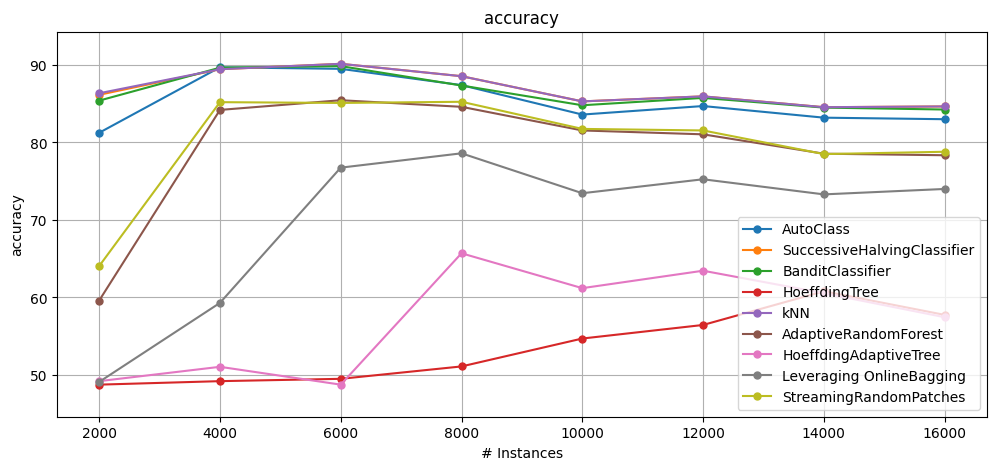

In [24]:
stream = RBFm_100k()
max_instances = 15000
window_size = 2000
budget = max_instances
test_autoclass_vs_successive_halving(stream, window_size=window_size, max_instances=max_instances, budget=budget, bandit_eps=0.3)

The RBFm_100k stream presents a different scenario where SuccessiveHalvingClassifier achieves the highest accuracy at 87.013%, slightly outperforming the default KNN (87.040%) and BanditClassifier (86.787%). Enhanced AutoClass falls behind at 85.427%. Computationally, BanditClassifier completes in 126.094s, approximately half the time of SuccessiveHalvingClassifier (250.490s) and a quarter of Enhanced AutoClass's time (494.321s).

All three methods dramatically outperform the default HoeffdingTree (53.153%), demonstrating the value of parameter optimization on this complex stream. The efficiency-accuracy trade-off is most favorable for SuccessiveHalvingClassifier here, as it achieves the best accuracy while requiring only half the computational resources of AutoClass. BanditClassifier offers a compelling alternative when processing time is critical, sacrificing only 0.23% accuracy compared to SuccessiveHalvingClassifier while running twice as fast.

#### Custom stream with drift


COMPARING AUTOCLASS WITH CONFIG, SUCCESSIVE HALVING, AND BANDIT CLASSIFIER
Enhanced AutoClass configuration saved to 'enhanced_autoclass_config.json'
Total number of model configurations: 33
Using 33 provided base classifiers
[<capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e767399090>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e767172c90>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e767177510>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e76718a210>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e76718a250>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e7671423d0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e767143090>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e767141650>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e767140f50>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e767143190>, <c

(<capymoa.evaluation.results.PrequentialResults at 0x78e8aec8de90>,
 <capymoa.evaluation.results.PrequentialResults at 0x78e767cc79d0>)

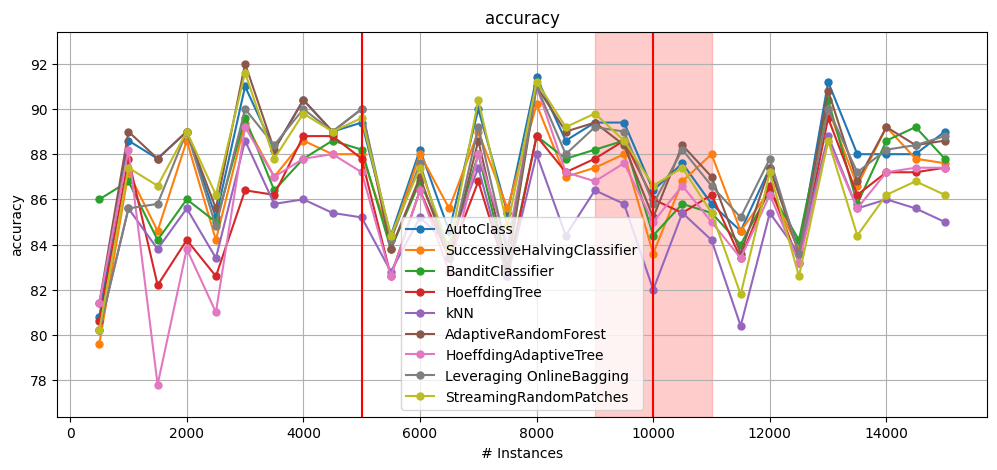

In [25]:
window_size=500
max_instances=15000
budget=max_instances*3
drift_stream = DriftStream(
    stream=[
        SEA(function=1),
        AbruptDrift(position=5000),
        SEA(function=3),
        GradualDrift(position=10000, width=2000),
        SEA(function=1),
    ]
)
test_autoclass_vs_successive_halving(drift_stream, window_size=window_size, max_instances=max_instances, budget=budget, bandit_eps=0.3)

For the custom stream with drift, Enhanced AutoClass achieves the highest accuracy at 87.680%, followed by SuccessiveHalvingClassifier (86.820%) and BanditClassifier (86.113%). All three outperform the default HoeffdingTree (85.933%), though with diminishing returns. The execution times vary significantly: BanditClassifier completes in 83.838s, SuccessiveHalvingClassifier in 178.488s, and Enhanced AutoClass in 226.214s. The accuracy differences between the methods are relatively small (1.57% between highest and lowest), while the computational differences are substantial (AutoClass takes 2.7x longer than BanditClassifier).

On this stream, BanditClassifier offers the most favorable efficiency-accuracy trade-off for time-sensitive applications, as it sacrifices only 0.71% accuracy compared to SuccessiveHalvingClassifier while running more than twice as fast. Among default models, AdaptiveRandomForest performs competitively at 87.500% accuracy, highlighting that sophisticated model selection is not always necessary when certain default models already perform well.

#### Custom stream with concept drift


COMPARING AUTOCLASS WITH CONFIG, SUCCESSIVE HALVING, AND BANDIT CLASSIFIER
Enhanced AutoClass configuration saved to 'enhanced_autoclass_config.json'
Total number of model configurations: 33
Using 33 provided base classifiers
[<capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e7671d9590>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e7671da750>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e7671da290>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e766e1bb90>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e7671f76d0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e766e1a110>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e766e13910>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e766f0b190>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e766e330d0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x78e7671d94d0>, <c

(<capymoa.evaluation.results.PrequentialResults at 0x78e766e0bf50>,
 <capymoa.evaluation.results.PrequentialResults at 0x78e766e09850>)

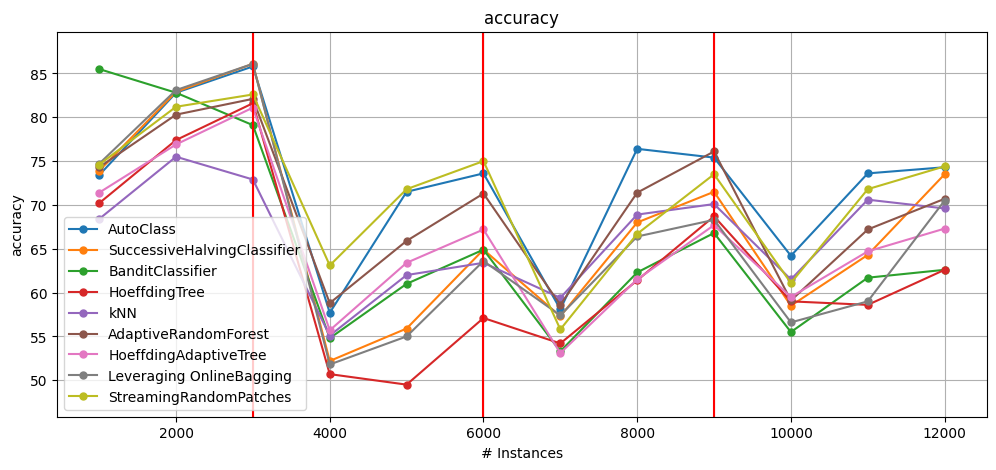

In [26]:
concept_length = 3000
max_instances = concept_length * 4
window_size = 1000

# Create a stream with multiple concept drifts
drift_stream = DriftStream(
    stream=[
        RandomTreeGenerator(tree_random_seed=1),
        AbruptDrift(position=concept_length),
        RandomTreeGenerator(tree_random_seed=2),
        AbruptDrift(position=concept_length * 2),
        RandomTreeGenerator(tree_random_seed=3),
        AbruptDrift(position=concept_length * 3),
        RandomTreeGenerator(tree_random_seed=4),
    ]
)

test_autoclass_vs_successive_halving(drift_stream, max_instances, window_size, budget=max_instances*3, bandit_eps=0.3)

On the challenging custom stream with concept drift, Enhanced AutoClass clearly outperforms with 72.100% accuracy, compared to SuccessiveHalvingClassifier (67.417%) and BanditClassifier (66.817%). The computational requirements vary dramatically: BanditClassifier completes in 105.817s, SuccessiveHalvingClassifier in 213.327s, and Enhanced AutoClass in 776.176s. The accuracy gap of 5.28% between AutoClass and SuccessiveHalvingClassifier, coupled with AutoClass taking 3.6x longer, presents a significant trade-off decision.

BanditClassifier and SuccessiveHalvingClassifier achieve similar accuracies (difference of only 0.6%), with BanditClassifier being twice as fast. This suggests that in concept drift scenarios, Enhanced AutoClass's thorough approach to model selection provides substantial benefits for accuracy, albeit at a high computational cost. Among default models, StreamingRandomPatches performs relatively well (70.967%), indicating that ensemble methods may be particularly suited for concept drift.

#### **Overall Analysis**

Across all tested streams, the three model selection approaches demonstrate consistent patterns in their accuracy-efficiency trade-offs:

AutoClass consistently delivers the highest or near-highest accuracy (except on RBFm_100k) but requires substantially more computational resources, with processing times typically 2-7x longer than BanditClassifier. It excels particularly in challenging scenarios with concept drift, where thorough exploration of the model space proves valuable.

SuccessiveHalvingClassifier offers a balanced middle ground, typically achieving accuracy within 0.5-5% of Enhanced AutoClass while requiring 40-70% less processing time. It performs particularly well on the Electricity and RBFm_100k streams, where it matches or exceeds AutoClass's accuracy at a fraction of the computational cost.

BanditClassifier prioritizes computational efficiency, running approximately 40-50% faster than SuccessiveHalvingClassifier and 70-85% faster than Enhanced AutoClass across all streams. However, this comes at an accuracy cost, typically 0.2-7% below the best-performing method. BanditClassifier struggles particularly on the Electricity stream but performs competitively on RBFm_100k and streams with mild drift.

The effectiveness of these approaches relative to default models varies by stream. On streams where default models already perform well (e.g., custom stream with drift where AdaptiveRandomForest achieves 87.500%), the benefits of sophisticated model selection are marginal. However, on more challenging streams like RBFm_100k, where default models struggle significantly, all three selection methods provide substantial improvements.

These results suggest that the choice between these approaches should be guided by the specific application requirements:

1. For applications where maximizing accuracy is critical and computational resources are available, Enhanced AutoClass is preferable.

2. For scenarios requiring a balance between accuracy and efficiency, SuccessiveHalvingClassifier offers the best compromise.

3. For time-sensitive or resource-constrained applications, BanditClassifier provides reasonable accuracy improvements with minimal computational overhead.

The consistent performance patterns across diverse streams demonstrate that these model selection approaches provide valuable alternatives for different computational budgets and accuracy requirements in stream learning environments